# Model - Convolutional Neural Network

In the case of the CNN classifier, we applied word-embedding procedures
from the pre-processed texts using the word2vec API of Python Package, Gensim. The word vectors were pretrained
with the training dataset collected for the current study with continuous bag-of-words representation
(CBOW) models, while the size of window was set to five. Note that by using the pre-trained word2vec model
for representing each post for each subreddit, a language style used by users who write posts in a subreddit can
be trained for the specific subreddit.

##### Import libraries

In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# For handling imbalanced classes
from collections import Counter
from imblearn.over_sampling import SMOTE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.layers import Flatten, Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GlobalMaxPooling1D

##### Load data

In [25]:
posts = pd.read_csv('../data/posts-preprocessed.csv')

In [26]:
posts.head(1)

,author,created_utc,subreddit,timeframe,text_clean,sent_tokens,word_tokens
0,sub30605,1499390694,bulimia,pre-covid,chest anyone else experience chest purging kno...,['chest anyone else experience chest purging k...,"['chest', 'anyone', 'else', 'experience', 'che..."


##### Binarize targets using get_dummies

Will use each subreddit as target

In [27]:
posts = pd.get_dummies(posts, columns=['subreddit'])

### Tokenizing the raw text

We will vectorize the text and prepare a training and validation split

In [28]:
texts = posts['text_clean']

In [29]:
maxlen = 1000 # Cuts off posts after 1000 words
max_words = 5000 # Considers the top specified number of words in the dataset

In [ ]:
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences, maxlen=maxlen)

### Parcing the word2vec embeddings File

We will use our previously created word2vec embeddings

#### Parsing the word-embeddings files

In [10]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [11]:
embedding_dim = 50 # Come back to this, still don't really understand how embedding dimensions affect things

embedding_matrix = create_embedding_matrix('../embedding_word2vec.txt',
                                           tokenizer.word_index, embedding_dim)

In [12]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7723224480474994

This means about 77% of the vocabulary is covered by the pre-trained model... that doesn't seem great.. maybe we can achieve better coverage by tweaking our word2vec model in the previous notebook. 

In [13]:
X = data

# Subreddit: Anxiety

In [14]:
labels = posts['subreddit_Anxiety']

In [15]:
labels = np.asarray(labels)
print('Shape of data:', data.shape)
print('Shape of label:', labels.shape)

Shape of data: (84879, 1000)
Shape of label: (84879,)


#### Train test split

In [16]:
y = labels

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = .2,
                                                    random_state=42)

SMOTE for class imbalance

In [18]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with the imbalanced classes

In [19]:
counter = Counter(y_train)
print(counter)

Counter({0: 60349, 1: 7554})


Above we see the extent to which our classes are imbalanced, our "non-anxiety" class has 50,349 observations and our "anxiety" class has 7544 observations.

Help from: https://realpython.com/python-keras-text-classification/

In [20]:
embedding_dim = 100

model1 = Sequential()
model1.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model1.add(layers.Conv1D(128, 5, activation='relu'))
model1.add(layers.GlobalMaxPooling1D())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         2189500   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,254,929
Trainable params: 2,254,929
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model1.fit(X_train, y_train,
                    epochs= 2, # Change this number for early stopping based on results
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/5
6791/6791 [==============================] - 274s 40ms/step - loss: 0.2849 - accuracy: 0.8994 - val_loss: 0.2460 - val_accuracy: 0.9066
Epoch 2/5
6791/6791 [==============================] - 265s 39ms/step - loss: 0.2098 - accuracy: 0.9210 - val_loss: 0.2453 - val_accuracy: 0.9095
Epoch 3/5
6791/6791 [==============================] - 278s 41ms/step - loss: 0.1565 - accuracy: 0.9437 - val_loss: 0.2913 - val_accuracy: 0.8853
Epoch 4/5
6791/6791 [==============================] - 271s 40ms/step - loss: 0.0878 - accuracy: 0.9693 - val_loss: 0.3992 - val_accuracy: 0.9002
Epoch 5/5
6791/6791 [==============================] - 279s 41ms/step - loss: 0.0490 - accuracy: 0.9836 - val_loss: 0.4866 - val_accuracy: 0.8914
Training Accuracy: 0.9902
Testing Accuracy:  0.8914


NameError: name 'plot_history' is not defined

### Define function to plot the accuracy scores

In [22]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### Plot accuracy scores and loss values

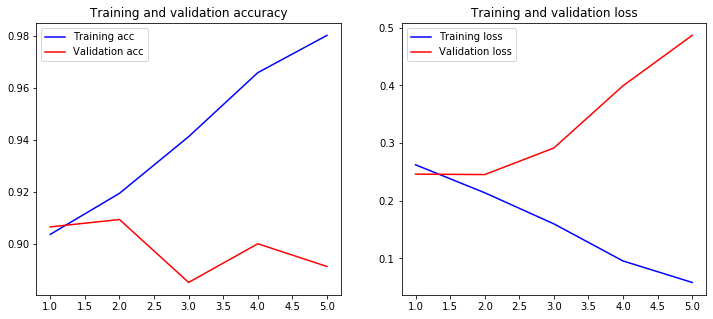

In [23]:
plot_history(history)
plt.savefig('../images/anxiety_cnn_imbal.png');

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)

In [ ]:
# ROC AUC
auc = roc_auc_score(testy, yhat_probs)
print('ROC AUC: %f' % auc)

In [ ]:
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

#### Defining a model using SMOTE to balance the classes

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

In [ ]:
embedding_dim = 100

model1_sm = Sequential()
model1_sm.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model1_sm.add(layers.Conv1D(128, 5, activation='relu'))
model1_sm.add(layers.GlobalMaxPooling1D())
model1_sm.add(layers.Dense(10, activation='relu'))
model1_sm.add(layers.Dense(1, activation='sigmoid'))
model1_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1_sm.summary()

In [ ]:
history = model1_sm.fit(X_train_sm, y_train_sm,
                    epochs= 5, # employ early stopping at around N epochs 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64) # number of samples before updating the internal model parameters

In [ ]:
loss, accuracy = model1_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

### Plot accuracy scores and loss values

In [ ]:
plot_history(history)
plt.savefig('../images/anxiety_cnn_smote.png');

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)

In [ ]:
# ROC AUC
auc = roc_auc_score(testy, yhat_probs)
print('ROC AUC: %f' % auc)

In [ ]:
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

# Subreddit: Anorexia Nervosa

In [ ]:
labels = posts['subreddit_AnorexiaNervosa']

#### Train test split

In [ ]:
X = data
y = labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = .2,
                                                    random_state=42)

SMOTE for class imbalance

In [ ]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with the imbalanced classes

In [ ]:
counter = Counter(y_train)
print(counter)

Above we see the extent to which our classes are imbalanced, our "non-anorexia nervosa" class has 60,170 observations and our "anorexia nervosa" class has 7733 observations.

In [ ]:
embedding_dim = 100

model2 = Sequential()
model2.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2.add(layers.Conv1D(128, 5, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

In [ ]:
history = model2.fit(X_train, y_train,
                    epochs=3, # Change this number for early stopping
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
plot_history(history)
plt.savefig('../images/anorexia_cnn_imbal.png');

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)

In [ ]:
# ROC AUC
auc = roc_auc_score(testy, yhat_probs)
print('ROC AUC: %f' % auc)

In [ ]:
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)

#### Defining a model using SMOTE to balance the classes

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

#### Defining a model

In [ ]:
embedding_dim = 100

model2_sm = Sequential()
model2_sm.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model2_sm.add(layers.Conv1D(128, 5, activation='relu'))
model2_sm.add(layers.GlobalMaxPooling1D())
model2_sm.add(layers.Dense(10, activation='relu'))
model2_sm.add(layers.Dense(1, activation='sigmoid'))
model2_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2_sm.summary()

In [ ]:
history = model2_sm.fit(X_train_sm, y_train_sm,
                    epochs= 50, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

loss, accuracy = model2_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_history(history)
plt.savefig('../images/anorexia_cnn_smote.png');

# Subreddit: Bulimia

In [ ]:
labels = posts['subreddit_bulimia']

#### Train test split

In [ ]:
X = data
y = labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size = .2,
                                                    random_state=42)

SMOTE for class imbalance

In [ ]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with the imbalanced classes

In [ ]:
counter = Counter(y_train)
print(counter)

Above we see the extent to which our classes are imbalanced, our "non-bulimia" class has 60,106 observations and our "bulimia" class has 7797 observations.

In [ ]:
embedding_dim = 100

model3_sm = Sequential()
model3_sm.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model3_sm.add(layers.Conv1D(128, 5, activation='relu'))
model3_sm.add(layers.GlobalMaxPooling1D())
model3_sm.add(layers.Dense(10, activation='relu'))
model3_sm.add(layers.Dense(1, activation='sigmoid'))
model3_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3_sm.summary()

In [ ]:
history = model3.fit(X_train, y_train,
                    epochs= 20, # employ early stopping at around N epochs 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_history(history)
plt.savefig('../images/bulimia_cnn_imbal.png');

#### Defining a model using SMOTE to balance the classes

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

#### Defining a model

In [ ]:
model3_sm = Sequential()
model3_sm.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model3_sm.add(layers.GlobalMaxPool1D())
model3_sm.add(layers.Dense(10, activation='relu'))
model3_sm.add(Dropout(0.25))
model3_sm.add(layers.Dense(1, activation='sigmoid'))
model3_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3_sm.summary()

In [ ]:
history = model3_sm.fit(X_train_sm, y_train_sm,
                    epochs=20, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model3_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_history(history)
plt.savefig('../images/bulimia_cnn_smote.png');

# Subreddit: Schizophrenia

In [ ]:
labels = posts['subreddit_schizophrenia']

#### Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size = .2,
                                                    random_state=42)

In [ ]:
smote = SMOTE(random_state=42) 
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

#### Defining a model with imbalanced classes

In [ ]:
counter = Counter(y_train)
print(counter)

In [ ]:
model4 = Sequential()
model4.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model4.add(layers.GlobalMaxPool1D())
model4.add(layers.Dense(10, activation='relu'))
model4.add(Dropout(0.25))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model4.summary()

In [ ]:
history = model4.fit(X_train, y_train,
                    epochs= 30, # employ early stopping at around N epochs 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=65)
loss, accuracy = model4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_history(history)
plt.savefig('../images/schiz_cnn_imbal.png');

#### Defining a model using SMOTE to balance the classes

In [ ]:
counter_resampled = Counter(y_train_sm) 
print(counter_resampled)

As we see above, using the SMOTE algorithm balances our classes... let's see how this effects our model.

#### Defining a model

In [ ]:
model4_sm = Sequential()
model4_sm.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model4_sm.add(layers.GlobalMaxPool1D())
model4_sm.add(layers.Dense(10, activation='relu'))
model4_sm.add(Dropout(0.25))
model4_sm.add(layers.Dense(1, activation='sigmoid'))
model4_sm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model4_sm.summary()

In [ ]:
history = model4_sm.fit(X_train_sm, y_train_sm,
                    epochs=20, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model4_sm.evaluate(X_train_sm, y_train_sm, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4_sm.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plot_history(history)
plt.savefig('../images/schiz_cnn_smote.png');

# CNN with all subreddits

In [ ]:
labels = posts.drop(columns = ['word_tokens', 'sent_tokens', 'text_clean', 'timeframe', 'created_utc', 'author'])

In [ ]:
labels.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    stratify = y,
                                                    test_size = .2,
                                                    random_state=42)

In [ ]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = modelfit(X_train, y_train,
                    epochs=5, # try early stopping at N epochs... 
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

In [ ]:
loss, accuracy = model(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model(X_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))